
# Zoidberg

## Introduction

Ce projet vise à comparer deux approches de machine learning - les réseaux de neurones convolutifs (CNN) et les K-Nearest Neighbors (KNN) - pour détecter la pneumonie à partir d'images de radiographie. Nous évaluerons ces modèles en fonction de leur précision, de leur perte, et d'autres métriques pertinentes, incluant les faux négatifs, faux positifs, et des graphiques tels que la matrice de confusion et la courbe ROC.

<style>
h1 {color: navy;}
h2 {color: navy;}
</style>



## Structure du Dataset

Le dataset se compose de trois dossiers principaux :
- **train** : utilisé pour l'entraînement des modèles
- **val** : utilisé pour la validation des modèles après l'entraînement
- **test** : utilisé pour tester les modèles

Chaque dossier contient deux sous-dossiers :
- **NORMAL** : contient des images de radiographies normales
- **PNEUMONIA** : contient des images de radiographies avec pneumonie



## Filtrage des images avec ImageUtils

La classe ImageUtils est utilisée pour filtrer les images de radiographie afin de s'assurer qu'elles respectent certaines dimensions minimales. Elle permet aussi de récupérer des informations sur le contenu du dataset, comme par exemple le nombre total d'images, les tailles minimales et maximales, les largeurs et hauteurs moyennes, ainsi que le nombre d'images filtrées. Voici comment elle fonctionne :

```python
class ImageUtils:
    @staticmethod
    def filter_images(data_dir, img_size=(256, 256)):
        """
        Filter out images that are too small and gather statistics on the image sizes.
        """
        min_img_size = (img_size[0] * 2, img_size[1] * 2)
        image_stats = {
            'total_images': 0,
            'min_size': (float('inf'), float('inf')),
            'max_size': (0, 0),
            'avg_width': 0,
            'avg_height': 0,
            'filtered_images': 0
        }
        filepaths = []
        total_width, total_height = 0, 0

        for dirpath, _, filenames in os.walk(data_dir):
            for filename in filenames:
                if filename.lower().endswith(('png', 'jpg', 'jpeg')):
                    filepath = os.path.join(dirpath, filename)
                    with Image.open(filepath) as img:
                        width, height = img.size
                        image_stats['total_images'] += 1
                        total_width += width
                        total_height += height
                        if width < min_img_size[0] or height < min_img_size[1]:
                            image_stats['filtered_images'] += 1
                        else:
                            filepaths.append(filepath)
                            image_stats['min_size'] = (
                                min(image_stats['min_size'][0], width),
                                min(image_stats['min_size'][1], height)
                            )
                            image_stats['max_size'] = (
                                max(image_stats['max_size'][0], width),
                                max(image_stats['max_size'][1], height)
                            )
                            image_stats['avg_width'] += width
                            image_stats['avg_height'] += height

        remaining_images = image_stats['total_images'] - image_stats['filtered_images']
        if remaining_images > 0:
            image_stats['avg_width'] /= remaining_images
            image_stats['avg_height'] /= remaining_images

        image_stats['avg_width'] = round(image_stats['avg_width'])
        image_stats['avg_height'] = round(image_stats['avg_height'])

        filtered_filepaths = [fp for fp in filepaths if
                              Image.open(fp).size[0] >= min_img_size[0] and Image.open(fp).size[1] >=
                              min_img_size[1]]
        return filtered_filepaths, image_stats
```



## Modèle KNN

Le modèle KNN (K-Nearest Neighbors) est un modèle de machine learning simple mais efficace pour la classification. Voici comment il est construit et utilisé dans ce projet :

### Prétraitement et création du dataset avec ImageUtils

Pour le modèle KNN, nous utilisons la classe `ImageUtils` pour filtrer et prétraiter les images de notre dataset. Nous choisissons une taille d'image plus petite (64x64) pour réduire la complexité computationnelle :

```python
data_handler = DataHandler(data_directory, image_size=(64, 64))
file_paths, image_stats = ImageUtils.filter_images(data_directory, img_size=(64, 64))
train_df, val_df = data_handler._create_dataframe(file_paths)
X_train, X_val, y_train, y_val = data_handler._create_datasets()
```

### Construction du modèle KNN

Le modèle KNN est construit en utilisant la bibliothèque `scikit-learn`. Voici les étapes de construction :

1. **Chargement et Prétraitement des Images** :

```python
X_train = np.array([self._load_image(fp) for fp in self.train_df['filepath']])
y_train = np.array([1 if label == 'PNEUMONIA' else 0 for label in self.train_df['class']])

X_val = np.array([self._load_image(fp) for fp in self.val_df['filepath']])
y_val = np.array([1 if label == 'PNEUMONIA' else 0 for label in self.val_df['class']])
```

2. **Entraînement du modèle** :

```python
self.model = KNeighborsClassifier(n_neighbors=n_neighbors)
self.scaler = StandardScaler()
X_train = self.scaler.fit_transform(X_train)
self.model.fit(X_train, y_train)
```

3. **Évaluation du modèle** :

```python
X_val = self.scaler.transform(X_val)
y_pred = self.model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
cm = confusion_matrix(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_proba)
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
```



## Résultats du modèle KNN


In [1]:

import json
import matplotlib.pyplot as plt
import numpy as np

# Chargement des résultats KNN
with open("knn_results.json", "r") as file:
    knn_results = json.load(file)

# Affichage des résultats KNN
print("## Résultats du modèle KNN\n- Précision: {}".format(knn_results['accuracy']))
print("- Rapport de classification:\n{}".format(knn_results['classification_report']))


## Résultats du modèle KNN
- Précision: 0.9342442356959864
- Rapport de classification:
              precision    recall  f1-score   support

      NORMAL       0.93      0.80      0.86       296
   PNEUMONIA       0.93      0.98      0.96       875

    accuracy                           0.93      1171
   macro avg       0.93      0.89      0.91      1171
weighted avg       0.93      0.93      0.93      1171




### Graphique KNN


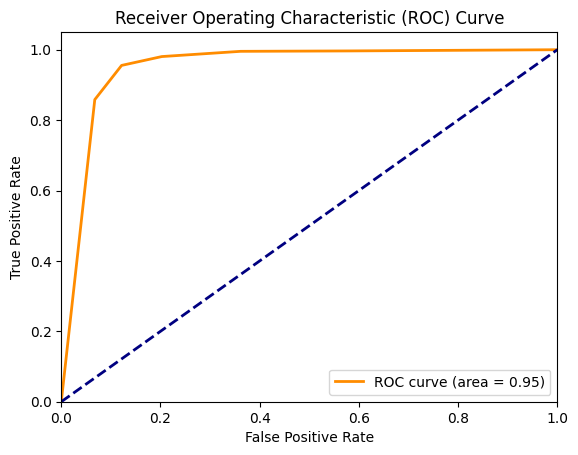

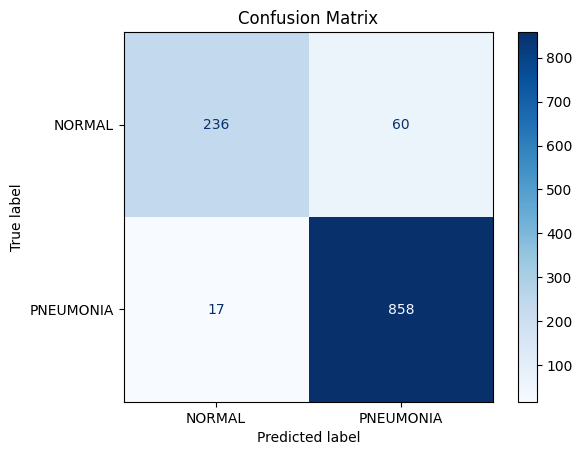

In [2]:

import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Chargement des résultats
with open("knn_results.json", "r") as file:
    knn_results = json.load(file)

# Convertir la matrice de confusion en tableau NumPy
cm = np.array(knn_results['confusion_matrix'])

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Plot ROC curve
plot_roc_curve(knn_results['fpr'], knn_results['tpr'], knn_results['roc_auc'])

# Plot Confusion Matrix
plot_confusion_matrix(cm)



## Modèle CNN

Le modèle CNN (Convolutional Neural Network) est un modèle de machine learning puissant pour la classification d'images. Voici comment il est construit et utilisé dans ce projet :

### Prétraitement et création du dataset avec ImageUtils

Pour le modèle CNN, nous utilisons également la classe `ImageUtils` pour filtrer et prétraiter les images

, mais avec une taille d'image plus grande (256x256) pour exploiter pleinement la capacité du modèle CNN :

```python
data_handler = DataHandler(data_directory, image_size=(256, 256))
file_paths, image_stats = ImageUtils.filter_images(data_directory, img_size=(256, 256))
train_df, val_df = data_handler._create_dataframe(file_paths)
train_ds = data_handler.get_dataset(data_handler.train_generator)
val_ds = data_handler.get_dataset(data_handler.validation_generator)
```

### Construction du modèle CNN

Le modèle CNN est construit en utilisant la bibliothèque `TensorFlow`. Voici les étapes de construction :

1. **Définition de l'architecture du modèle** :

```python
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
```

2. **Entraînement du modèle** :

```python
history = self.model.fit(
    train_ds,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=val_ds,
    validation_steps=val_steps
)
self.model.summary()
```

3. **Évaluation du modèle** :

```python
loss, accuracy = self.model.evaluate(test_ds, steps=test_steps)
y_true = []
y_pred = []
y_proba = []

for x, y in test_ds.take(test_steps):
    y_true.extend(y.numpy())
    preds = self.model.predict(x)
    y_pred.extend(np.where(preds >= 0.5, 1, 0))
    y_proba.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred).flatten()
y_proba = np.array(y_proba).flatten()

cm = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_proba)
fpr, tpr, _ = roc_curve(y_true, y_proba)
```



## Résultats du modèle CNN


In [3]:

import json
import matplotlib.pyplot as plt
import numpy as np

# Chargement des résultats CNN
with open("cnn_results.json", "r") as file:
    cnn_results = json.load(file)

# Affichage des résultats CNN
print("## Résultats du modèle CNN\n- Précision de test: {}".format(cnn_results['test_accuracy']))
print("- Perte de test: {}".format(cnn_results['test_loss']))


## Résultats du modèle CNN
- Précision de test: 0.9496221542358398
- Perte de test: 0.14307883381843567



### Graphique CNN


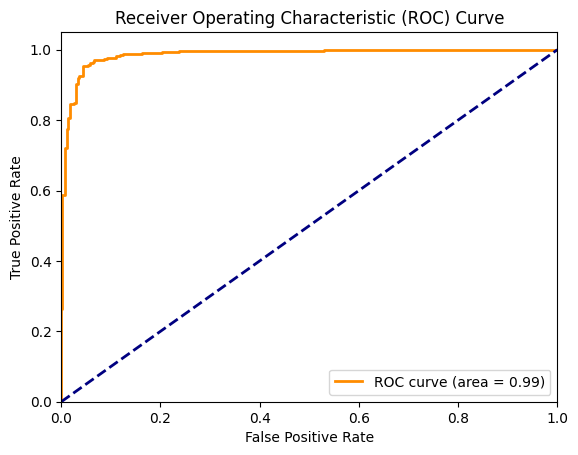

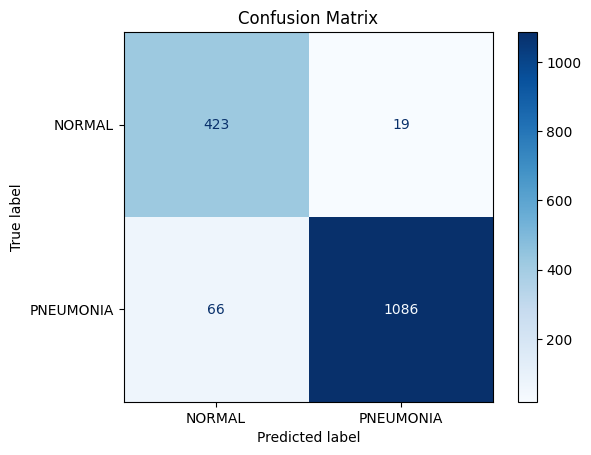

In [4]:

import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Chargement des résultats
with open("cnn_results.json", "r") as file:
    cnn_results = json.load(file)

# Convertir la matrice de confusion en tableau NumPy
cm = np.array(cnn_results['confusion_matrix'])

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Plot ROC curve
plot_roc_curve(cnn_results['fpr'], cnn_results['tpr'], cnn_results['roc_auc'])

# Plot Confusion Matrix
plot_confusion_matrix(cm)



## Comparaison de la précision


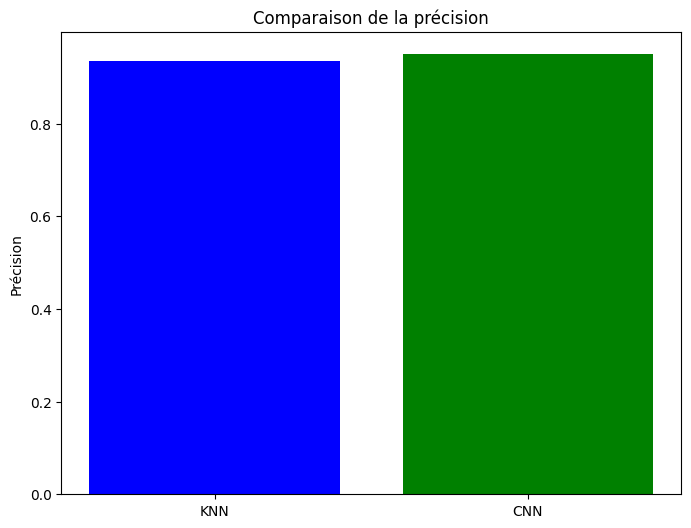

In [5]:

# Comparaison des résultats
labels = ['KNN', 'CNN']
accuracy = [knn_results['accuracy'], cnn_results['test_accuracy']]

# Création des graphiques
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracy, color=['blue', 'green'])
plt.title('Comparaison de la précision')
plt.ylabel('Précision')
plt.show()



## Conclusion

En comparant les deux modèles, nous observons que :

- Le modèle CNN montre une meilleure précision et un score AUC ROC plus élevé.
- Le modèle KNN reste une option valide et plus simple à implémenter.

### Recommandations

- **Modèle CNN** :
  - Plus fiable et précis pour la détection de la pneumonie.
  - Peut encore être amélioré avec un entraînement plus long.

- **Modèle KNN** :
  - Option simple et rapide à implémenter.
  - Utile dans des scénarios avec des ressources informatiques limitées.

Pour des applications nécessitant une haute précision et la capacité de traiter de grands ensembles de données avec des images complexes, le modèle CNN est recommandé. En revanche, pour des scénarios où les ressources informatiques sont limitées et une implémentation rapide est nécessaire, le modèle KNN peut être plus approprié.
